# Оценка балла сдачи экзамена по математике<a id="main">

* [Подготовка](#prepare)
* [Описание задачи](#intro)
* [EDA](#eda)
* [Baseline и предварительная оценка](#bl)
* [Создание и отбор признаков](#features)

-----


## Подготовка<a id="prepare">
[Оглавление](#main)

In [1]:
# допустимые зависимости
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# оговоривалось, что дерево решений можно заимствовать встроенное
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# этих зависимостей не было в списке, если их отсутствие здесь действительно критично, прошу указать это
import os
from pathlib import Path



from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [2]:
class BootstrapAggregation():
    '''
    Алгоритм, основанный на усреднении предсказаний ряда базовых алгоритмов.

    Parameters:
    -----------
    algorithm: type
        Тип базового алгоритма, участвующего в bootstrap агрегации.
        Гиперпараметры передаются сразу после указания всех параметров для BootstrapAggregation.
            ВАЖНО: передавать следует сам тип, а не экземпляр алгоритма: например,
            DecisionTreeClassifier вместо DecisionTreeClassifier().
    alg_count: int
        Количество базовых алгоритмов, участвующих в обучении.
    sample_size: int
        Размер перемешанной выборки с возвращением, участвующей в обучении.
    features_in_sample: int
        Количество признаков, участвующие в обучении.
    OOB: bool
        Метка, указывающая, следует ли активировать механизм Out-of-Bag.
        При нем выборка, не участвовавшая в процессе обучения используется для предсказания результатов,
        тем самым убирая необходимость использования кросс-валидации.
    '''

    def __init__(self, algorithm,
                 predict_type: str='regression',
                 alg_count=50,
                 sample_size=None,
                 features_in_sample=None,
                 OOB=False, **kwargs):
        if isinstance(algorithm, type):
            self.__algorithm = algorithm
        else:
            raise TypeError(
                'В "algorithm" принимается тип алгоритма, но не экземпляр базовой модели.')
        self.predict_type = predict_type
        self.__alg_count = alg_count if alg_count > 1 else 1
        self.__s_size = sample_size
        self.__s_features = features_in_sample
        self.__OOB = OOB
        self.__kw = kwargs

    def _get_bootstrap(self, data, samle_size, features_size):
        np.random.seed(self.__kw.get('random_state'))
        try:
            ind = data.index
            features = data.columns
        except AttributeError as e:
            ind = np.arange(data.shape[0])
            features = np.arange(data.shape[1])
        bootstrap_ind = np.random.choice(ind, replace=True, size=samle_size)
        feature_subsample = np.random.choice(features, replace=False, size=features_size)
        
        return feature_subsample, bootstrap_ind

    def fit(self, X, y):
        '''
        Обучает модель.

        Parameters:
        -----------
        X, y: array like
            Значения признаков и целевой переменной
        '''
        self.__models = []
        self.__OOB_predicts = np.empty_like(y).astype('float')
        self.__OOB_predicts[:] = np.nan
        y_ind = np.arange(y.shape[0])
        s_features = self.__s_features
        s_size = self.__s_size
        if s_features is None:
            s_features = int(X.shape[1]**0.5)
        if s_size is None:
            s_size = X.shape[0]
        elif s_size <= 1:
            s_size = int(X.shape[0] * s_size)

        for i in range(self.__alg_count):
            b_labels, b_rows = self._get_bootstrap(X, s_size, s_features)
            try:
                b_X = X.loc[b_rows, b_labels].copy()
                b_y = y.loc[b_rows].copy()
            except AttributeError as e:
                b_X = X[b_rows][:, b_labels].copy()
                b_y = y[b_rows].copy()
            model = self.__algorithm
            self.__models.append([model(**self.__kw), b_labels])
            self.__models[i][0].fit(b_X, b_y)
            if self.__OOB:
                # TODO: оптимизировать, чтобы предсказания каждого алгоритма производились не по всей X перед отбором наблюдений
                y_pred = self.__models[i][0].predict(X[:, self.__models[i][1]])
                y_pred = np.where(np.isin(y_ind, b_rows), np.nan, y_pred)
                self.__OOB_predicts = np.vstack(
                    [self.__OOB_predicts, y_pred.copy()])
                
            if self.__kw.get('random_state') is not None:
                self.__kw['random_state'] += 1
        if self.__OOB:
            self.__OOB_predicts = np.nanmean(self.__OOB_predicts.T, axis=1)

    def predict_OOB(self):
        '''
        Отдает вероятность принадлежности объекта к классу 1 для не принимающих
        в обучении наблюдений в bootstrap выборке.
        Для каждого базового алгоритма вычисляется принадлежность к классу в self.fit() и в итоге усредняется. 


        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
        return self.__OOB_predicts

    def predict_proba(self, X):
        '''
        Отдает вероятность принадлежности объекта к классу 1.

        Parameters:
        -----------
        X: array like
            Значения признаков

        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
        predicts = None
        for model in self.__models:
            try:
                pred = model[0].predict(X[model[1]])
            except:
                pred = model[0].predict(X[:, model[1]])
            if predicts is None:
                predicts = pred.reshape(-1, 1)
            else:
                predicts = np.hstack(
                    (predicts.copy(), pred.reshape(-1, 1)))
        return predicts.mean(axis=1)

    def predict(self, X, prob=0.5):
        '''
        Отдает предсказания обученной модели.

        Parameters:
        -----------
        X: array like
            Значения признаков

        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
        pred = self.predict_proba(X)
        if self.predict_type == 'classification':
            pred = np.where(pred < prob, 0, 1)
        return pred

    def fit_predict(self, X, y):
        '''
        Обучает модель и отдает ее предсказания.

        Parameters:
        -----------
        X, y: array like
            Значения признаков и целевой переменной

        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
        self.fit(X, y)
        return self.predict(X)

In [31]:
class Kmeans:
    def __init__(self, k, max_iterations=50, min_distance=1e-7, N=2):
        self.__k = k
        self.__max_iterations = max_iterations
        self.__min_distance = min_distance
        self.__N = N
        
    def _distance(self, X, centroid):
        return (np.abs((X - centroid)**self.__N).sum(axis=1)**(1/self.__N))
        
    def fit(self, X, pref_feature=None):
        X['cluster'] = 0
#         X.reset_index(inplace=True, drop=True)

        df_distance = pd.DataFrame()
        self.__centroids = X.head(self.__k)
        if pref_feature is None:
            self.__centroids = self.__centroids.reset_index(drop=True)
        else:
            self.__centroids = self.__centroids.sort_values(pref_feature).reset_index(drop=True)
        old_centroids = self.__centroids.copy()
        
        for _ in range(1, self.__max_iterations):
            for i in range(self.__k):
                df_distance[i] = self._distance(X, self.__centroids.loc[i])
                
            X['cluster'] = df_distance.idxmin(axis=1)
            self.__centroids = X.copy().groupby('cluster').mean().reset_index(drop=True)
            if pref_feature is not None:
                self.__centroids = self.__centroids.sort_values(pref_feature).reset_index(drop=True)
                
            if abs(self.__centroids - old_centroids).sum().sum() < self.__min_distance:
                break
            old_centroids = self.__centroids.copy()
    
    def predict_distance(self, X):
        df_distance = pd.DataFrame()
        for i in range(self.__k):
            df_distance[i] = self._distance(X, self.__centroids.loc[i])
        return df_distance
    
    def predict(self, X):
        pred = self.predict_distance(X)
        return pred.idxmin(axis=1)
    
    def get_centroids(self):
        return self.__centroids

In [8]:
class Scaler:
    def __init__(self):
        pass
    
    def fit(self, X):
        self.__stat_dict = dict()
        for column in X.columns:
            self.__stat_dict[column] = (X[column].mean(), X[column].std())
    
    def transform(self, X):
        Xc = X.copy()
        for column in Xc.columns:
            Xc[column] = (Xc[column] - self.__stat_dict[column][0]) / self.__stat_dict[column][1]
        return Xc

In [9]:
def r2_score(y_pred: np.array, labels: np.array):
    sigma2 = (labels - y_pred)**2
    sigmay2 = (labels - labels.mean())**2
    return 1 - sigma2.sum() / sigmay2.sum()

def mean_distance(clusters, centroids):
    dist = np.array([])

    for cluster, points in clusters.items():
        cls_dist = ((points - centroids.loc[cluster])**2).sum(1)**0.5
        dist = np.append(dist, cls_dist)
    return dist.mean()

def feature_importance(X, model):
    res_dict_test = dict()

    for clm in X.columns:
        X_shuffle_test = X.copy()
        X_shuffle_test[clm] = np.random.permutation(X_shuffle_test[clm])
        pred_test = model.predict(X_shuffle_test)
        res_dict_test[clm] = r2_score(pred_test, y_test)
        
    return res_dict_test

------


## Описание задачи<a id='intro'>
[Оглавление](#main)

В данной работе на <a href="https://www.kaggle.com/c/tutors-expected-math-exam-results/overview">тренировочном датасете</a> будет предсказываться результат сдачи экзамена по математике в зависимости от выбранного репетитора.<br> Всего присутствует 11 фичей:
* Id
* age
* years_of_experience
* lesson_price
* qualification
* physics
* chemistry
* biology
* english
* geography
* history

И таргет:
* mean_exam_points


Результат будет оцениваться по коэффициенту детерминации (или доли объясненной дисперсии):
$$R^2 = 1 - \frac{\sigma^2}{\sigma_y^2}$$, где $\sigma^2$ - квадрат отклонений предсказанных значений от реальных, $\sigma_y^2$ - дисперсия целевой переменной

-----

## EDA<a id='eda'>
[Оглавление](#main)

Загрузим исходные данные и рассмотрим их в первом приближении:

In [10]:
data_path_name = 'data'

DATA_PATH = Path('./' + data_path_name)

os.system("kaggle competitions download -c tutors-expected-math-exam-results -f test.csv -p " + data_path_name)
os.system("kaggle competitions download -c tutors-expected-math-exam-results -f train.csv -p " + data_path_name)

TEST_DATASET = DATA_PATH / 'test.csv'
TRAIN_DATASET = DATA_PATH / 'train.csv'

In [11]:
df_train = pd.read_csv(TRAIN_DATASET)
df_test = pd.read_csv(TEST_DATASET)

df_train.drop(columns='Id', inplace=True)
df_test.drop(columns='Id', inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns='mean_exam_points'),
                                                    df_train['mean_exam_points'],
                                                    test_size=0.30, random_state=10)

df_train.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [12]:
df_train.describe()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,64.340800
std,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,13.536823
min,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
50%,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [20]:
df_train.isna().sum()

age                    0
years_of_experience    0
lesson_price           0
qualification          0
physics                0
chemistry              0
biology                0
english                0
geography              0
history                0
mean_exam_points       0
dtype: int64

*Предварительно признак `Id` исключен из анализа, т.к. не должен нести какой-либо полдезной нагрузки.*

Кажется, что предварительной очистки данные не требуют: нет явных выбросов в количественных фичах, `None` значения отсутствуют, все имеющиеся признаки не являются категориальными и с ними сразу же можно работать численными методами.

Отдельно стоит отметить признаки из категории знания определенных предметов (особенно гуманитарного характера): `physics`, `chemistry`, `biology`, `english`, `geography`, `history`. Возможно, в последующем захочется избавиться от них, если они не будут в сильной мере влиять на результат, особенно учитывая то, что все они (кроме `physics`) достаточно разреженные. Особенно усиливает этот факт то, что знание последних 5 предметов не должно давать сильный прирост к знанию математики.

Также хочется посмотреть общий вид распределений признаков и челевой переменной:

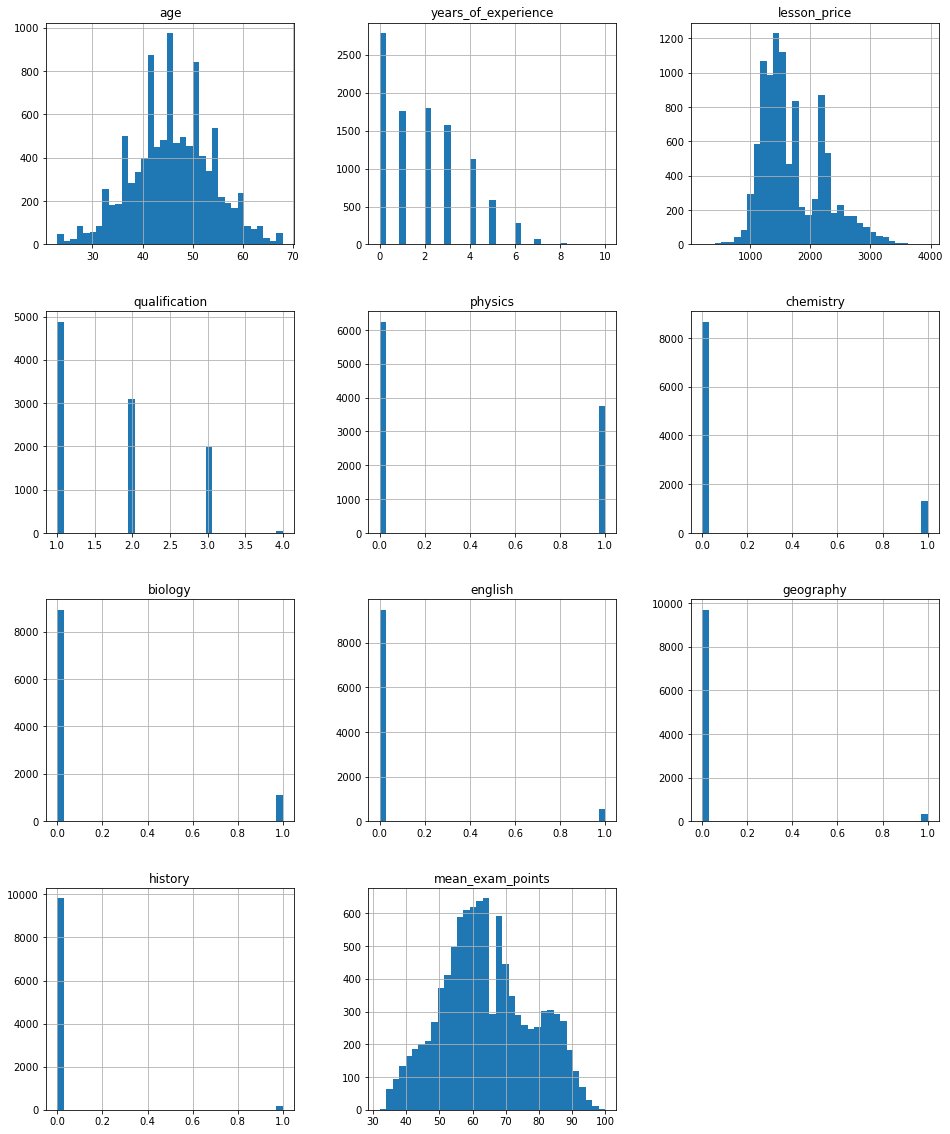

In [24]:
df_train.hist(figsize=(16,20), bins=35, grid=True, layout=(-1, 3));

На графиках `lesson_price` и `mean_exam_points` видно, что распределения представляют из себя несколько пиков, что наводит на мысль о том, что возможно выгодно будет кластеризовать выборку и строить модели на каждой ее части или номер кластера оставить как новый признак.

---------

## Baseline и предварительная оценка<a id="bl">
[Оглавление](#main)

Посмотрим опорную модель на основе модели случайного леса:

In [26]:
model = BootstrapAggregation(DecisionTreeRegressor,
                             random_state=30,
                             alg_count=300,
                             features_in_sample=len(X_train.columns),
                             sample_size=1)
model.fit(X_train, y_train)
pred = model.predict(X_train)
pred_test = model.predict(X_test)
print('train:', r2_score(pred, y_train))
print('test:', r2_score(pred_test, y_test))

train: 0.9475350854456458
test: 0.7358489769797054


Есть ощущение, что модель получается несколько переобученная. Для начала подберем размер выборки для обучений: 

При доле выборки в 0.095 R2 принимает максимальное значение - 0.77674


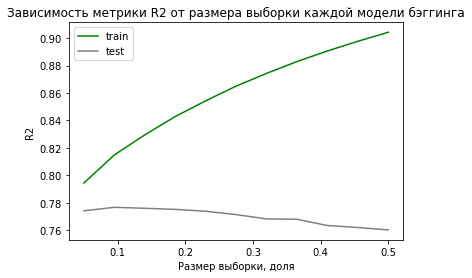

In [27]:
dict_train = dict()
dict_test = dict()
for i in np.linspace(0.05,0.5,11):
    model = BootstrapAggregation(DecisionTreeRegressor,
                             random_state=31,
                             alg_count=200,
                             features_in_sample=len(X_train.columns),
                             sample_size=i)
    model.fit(X_train, y_train)
    pred = model.predict(X_train)
    pred_test = model.predict(X_test)
    dict_train[i] = r2_score(pred, y_train)
    dict_test[i] = r2_score(pred_test, y_test)
    
perce, r2 = max(dict_test.items(), key=lambda x: x[1])
print(f'При доле выборки в {perce} R2 принимает максимальное значение - {round(r2, 5)}')

plt.plot(dict_train.keys(), dict_train.values(), color='green', label='train')
plt.plot(dict_test.keys(), dict_test.values(), color='grey', label='test')
plt.title('Зависимость метрики R2 от размера выборки каждой модели бэггинга')
plt.legend(loc='best')
plt.xlabel('Размер выборки, доля')
plt.ylabel('R2')
plt.show()

Скоррекутируем начальные гиперпараметры:

In [29]:
model = BootstrapAggregation(DecisionTreeRegressor,
                             random_state=30,
                             alg_count=300,
                             features_in_sample=len(X_train.columns),
                             sample_size=0.1)
model.fit(X_train, y_train)
pred = model.predict(X_train)
pred_test = model.predict(X_test)
print('train:', r2_score(pred, y_train))
print('test:', r2_score(pred_test, y_test))

train: 0.8175490568208877
test: 0.777051042515945


Для опорной модели безо всякой обработки данных значений получились достаточно высокие. Но далее постараемся еще хотя бы несколько повысить метрику.

**Базовое значение метрики: $R^2 = 0.77705$**

--------

## Создание и отбор признаков<a id="features">
[Оглавление](#main)

### *Кластеризация*

Как выло упомянуто ранее, попробуем создать признак, основанный на класетризации наблюдений.<br>
Для того, чтобы узнать оптимальное число кластеров, построим ряд моделей и вычислим среднее межгрупповое расстояние:

In [51]:
cluster_pivot = dict()
for i in range(1, 40):
    km_model = Kmeans(i)
    km_model.fit(df_train_cluster.drop(columns=clmns_to_drop), 'mean_exam_points')
    cluster_pred = km_model.predict(df_train_cluster.drop(columns=clmns_to_drop))
    df_distance = pd.DataFrame()
    dist = km_model.predict_distance(df_train_cluster)
    df_distance['distance'] = dist.min(1)
    df_distance['cluster'] = dist.idxmin(1)
    cluster_pivot[i] = df_distance.groupby('cluster').mean().reset_index(drop=True).mean()

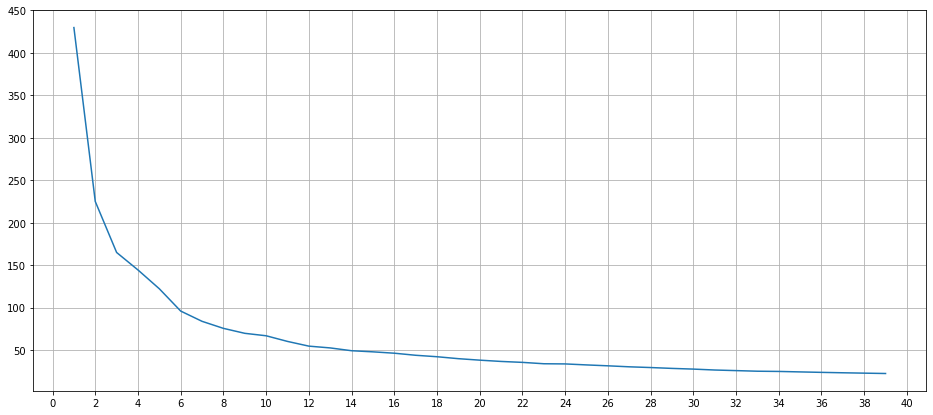

In [52]:
plt.figure(figsize = (16, 7))
plt.grid()
plt.xticks(np.arange(0, 42, 2))
plt.plot(cluster_pivot.keys(), cluster_pivot.values())
plt.show()

Так называемое "колено" образуется при 6 кластерах. Будем считать это количество оптимальным.<br>
Обучим модель `Kmeans` и создадим новый признак:

In [37]:
clmns_to_drop = []
clmns_to_drop = ['physics', 'chemistry', 'biology', 'english', 'geography', 'history']

df_train_cluster = X_train.copy()

scaler = Scaler()
scaler.fit(df_train_cluster)
df_train_cluster = scaler.transform(df_train_cluster)

df_train_cluster['mean_exam_points'] = y_train

km_model = Kmeans(6)
km_model.fit(df_train_cluster.drop(columns=clmns_to_drop), 'mean_exam_points')

pred_cluster = km_model.predict(df_train_cluster.drop(columns=clmns_to_drop))
df_train_cluster['cluster'] = pred_cluster

X_test_scaled = scaler.transform(X_test)
pred_test_cluster = km_model.predict(X_test_scaled.drop(columns=clmns_to_drop))
X_test_scaled['cluster'] = pred_test_cluster

print('train:', r2_score(pred_cluster, y_train))
print('test:', r2_score(pred_test_cluster, y_test))

train: -20.481734911107132
test: -20.28124646819594


In [41]:
X_test_scaled

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,cluster
937,0.883640,-1.127436,0.083232,0.343433,-0.773833,-0.398885,-0.351280,-0.237563,-0.180121,-0.147464,4
9355,-0.113998,-1.127436,-0.965511,-0.919851,-0.773833,-0.398885,-0.351280,-0.237563,-0.180121,-0.147464,1
2293,-0.862227,-0.000644,-0.679490,-0.919851,1.292083,-0.398885,2.846326,-0.237563,-0.180121,-0.147464,2
192,0.509526,-1.127436,-0.012108,0.343433,1.292083,-0.398885,-0.351280,-0.237563,-0.180121,-0.147464,4
8675,1.008345,1.126148,-0.393469,-0.919851,-0.773833,-0.398885,-0.351280,-0.237563,-0.180121,-0.147464,1
...,...,...,...,...,...,...,...,...,...,...,...
4964,1.631869,-1.127436,1.036635,1.606716,-0.773833,-0.398885,-0.351280,-0.237563,5.551016,-0.147464,5
8978,-2.358684,-0.564040,0.941295,0.343433,-0.773833,-0.398885,-0.351280,-0.237563,-0.180121,-0.147464,4
7540,0.509526,0.562752,0.750614,-0.919851,-0.773833,-0.398885,-0.351280,-0.237563,-0.180121,-0.147464,0
5275,-0.363408,-1.127436,-0.012108,0.343433,1.292083,-0.398885,-0.351280,-0.237563,-0.180121,-0.147464,4


In [ ]:
clmns_to_drop = ['chemistry', 'biology', 'english', 'geography', 'history', 'cluster']
X_train_scaled = df_train_cluster.drop(columns=['mean_exam_points'] + clmns_to_drop)
X_test_scaled = X_test_scaled.drop(columns=clmns_to_drop, errors='ignore')
y_train = df_train_cluster['mean_exam_points']

# new_model = BootstrapAggregation(DecisionTreeRegressor,
#                                 random_state=30,
#                                 alg_count=150,
#                                 features_in_sample=len(X_train_scaled.columns),
#                                 sample_size=0.1)
new_model = BootstrapAggregation(DecisionTreeRegressor,
                                random_state=30,
                                alg_count=300,
                                features_in_sample=int(len(X_train_scaled.columns)),
                                sample_size=0.1)

new_model.fit(X_train_scaled, y_train)
new_pred_train = new_model.predict(X_train_scaled)
new_pred_test = new_model.predict(X_test_scaled)

In [ ]:
r2_score(new_pred_train, y_train), r2_score(new_pred_test, y_test)

In [43]:
columns = X_train.columns
for i, clm in enumerate(columns):
    for clm2 in columns[:]:
#         X_train[f'{clm}_{clm2}'] = np.where(X_train[clm2] == 0, 1, X_train[clm] /  X_train[clm2])
#         X_test[f'{clm}_{clm2}'] = np.where(X_test[clm2] == 0, 1, X_test[clm] /  X_test[clm2])\
        
        X_train[f'{clm}_{clm2}'] = X_train[clm] *  X_train[clm2]
        X_test[f'{clm}_{clm2}'] = X_test[clm] *  X_test[clm2]

In [89]:
model = BootstrapAggregation(DecisionTreeRegressor,
                             random_state=30,
                             alg_count=200,
                             features_in_sample=len(X_train.columns),
                             sample_size=0.1)
model.fit(X_train, y_train)
pred = model.predict(X_train)
pred_test = model.predict(X_test)
print(r2_score(pred, y_train))
print(r2_score(pred_test, y_test))

0.8167843772646628
0.776564329840757


In [113]:
res_dict_test = feature_importance(X_test, model)
sorted(res_dict_test.items(), key=lambda item: item[1])

[('lesson_price', 0.019715521412047354),
 ('qualification', 0.41459771567932624),
 ('physics', 0.7083060764069405),
 ('years_of_experience', 0.7325082953095643),
 ('english', 0.7759230508808874),
 ('chemistry', 0.776115719590821),
 ('age', 0.7764204487421067),
 ('biology', 0.7764553978399438),
 ('history', 0.7766637736334079),
 ('geography', 0.7766706916931143)]

In [114]:
[k for k, v in res_dict_test.items() if v > 0.776564329840757]

['geography', 'history']

In [313]:
km_model = Kmeans(2)
# clmns_to_drop = ['mean_exam_points', 'years_of_experience', 'lesson_price', 'qualification']
clmns_to_drop = ['physics', 'chemistry', 'biology', 'english', 'geography', 'history']
clmns_to_drop_train = ['physics', 'chemistry', 'biology', 'english', 'geography', 'history', 'mean_exam_points']
# km_model.fit(df_train_cluster.drop(columns=['physics', 'chemistry', 'biology', 'english', 'geography', 'history']))
# cluster_pred = km_model.predict(df_train_cluster.drop(columns=['physics', 'chemistry', 'biology', 'english', 'geography', 'history']))

km_model.fit(df_train_cluster.drop(columns=clmns_to_drop))
cluster_pred = km_model.predict(df_train_cluster.drop(columns=clmns_to_drop))

In [122]:
clmns_to_drop = ['physics', 'chemistry', 'biology', 'english', 'geography', 'history']

df_train_cluster = X_train.copy()

scaler = Scaler()
scaler.fit(df_train_cluster)
df_train_cluster = scaler.transform(df_train_cluster)

df_train_cluster['mean_exam_points'] = y_train

km_model = Kmeans(6)
km_model.fit(df_train_cluster.drop(columns=clmns_to_drop), 'mean_exam_points')

pred_cluster = km_model.predict(df_train_cluster.drop(columns=clmns_to_drop))
df_train_cluster['cluster'] = pred_cluster

X_test_scaled = scaler.transform(X_test)
pred_test_cluster = km_model.predict(X_test_scaled.drop(columns=clmns_to_drop))
X_test_scaled['cluster'] = pred_test_cluster

In [136]:
X_test_scaled.loc[X_test_scaled['cluster'] == 0].index

Int64Index([4691, 7533,  209, 5905, 5142,  398, 1361, 4082, 4716, 2681,
            ...
            5257,   89, 1123, 8269, 2692, 1182, 2656, 5012, 9225, 7540],
           dtype='int64', length=504)

In [137]:
y_test[X_test_scaled.loc[X_test_scaled['cluster'] == 0].index]

4691    60.0
7533    63.0
209     64.0
5905    56.0
5142    58.0
        ... 
1182    37.0
2656    60.0
5012    60.0
9225    64.0
7540    47.0
Name: mean_exam_points, Length: 504, dtype: float64

In [124]:
np.unique(pred_cluster)

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [158]:
b_models = dict()
features_count = int(len(X_train_scaled.columns))

for cluster in np.unique(pred_cluster):
    b_models[cluster] = BootstrapAggregation(DecisionTreeRegressor,
                                random_state=30,
                                alg_count=300,
                                features_in_sample=features_count,
                                sample_size=0.1)
    X_loc = X_test_scaled.copy().loc[X_test_scaled['cluster'] == cluster]
    y_loc = y_test[X_loc.index]
    b_models[cluster].fit(X_loc, y_loc)

In [148]:
b_models[0].predict(X_test_scaled)

array([50.06421892, 56.54587765, 58.09484087, ..., 52.48050821,
       52.3304798 , 50.41577993])

In [159]:
X_test_scaled['pred'] = 0
for cluster, model in b_models.items():
    X_test_scaled.loc[X_test_scaled.cluster == cluster, 'pred'] = model.predict(X_test_scaled.loc[X_test_scaled.cluster == cluster])

In [160]:
r2_score(X_test_scaled['pred'], y_test)

0.6996170454641367

In [157]:
b_models[4].predict(X_test_scaled)

array([50.06421892, 56.54587765, 58.09484087, ..., 52.48050821,
       52.3304798 , 50.41577993])

In [156]:
y_test

937     68.0
9355    54.0
2293    69.0
192     70.0
8675    42.0
        ... 
4964    74.0
8978    74.0
7540    47.0
5275    74.0
9654    75.0
Name: mean_exam_points, Length: 3000, dtype: float64

In [15]:
X_test_scaled.apply()

NameError: name 'X_test_scaled' is not defined

In [52]:
X_train_cluster = df_train_cluster.drop(columns=['mean_exam_points', 'cluster'])
y_train_cluster = df_train_cluster.cluster

cluster_model = BootstrapAggregation(DecisionTreeClassifier,
                                     predict_type='classification',
                                     random_state=33,
                                     alg_count=150,
                                     features_in_sample=len(X_train_cluster.columns),
                                     sample_size=0.1)



cluster_model.fit(X_train_cluster, y_train_cluster)
pred_train_cluster = np.round(cluster_model.predict_proba(X_train_cluster)).astype('int')
pred_test_cluster = np.round(cluster_model.predict_proba(X_test_scaled)).astype('int')

X_test_scaled['cluster'] = pred_test_cluster

In [44]:
np.unique(pred_test_cluster, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int64),
 array([ 52,  81,  80, 459, 319, 430, 272,  53,  25,  36,   4,  11,  85,
        213, 283, 210,  41,  74,  69, 203], dtype=int64))

In [114]:
clmns_to_drop = ['chemistry', 'biology', 'english', 'geography', 'history', 'cluster']
X_train_scaled = df_train_cluster.drop(columns=['mean_exam_points'] + clmns_to_drop)
X_test_scaled = X_test_scaled.drop(columns=clmns_to_drop, errors='ignore')
y_train = df_train_cluster['mean_exam_points']

# new_model = BootstrapAggregation(DecisionTreeRegressor,
#                                 random_state=30,
#                                 alg_count=150,
#                                 features_in_sample=len(X_train_scaled.columns),
#                                 sample_size=0.1)
new_model = BootstrapAggregation(DecisionTreeRegressor,
                                random_state=30,
                                alg_count=300,
                                features_in_sample=int(len(X_train_scaled.columns)),
                                sample_size=0.1)

new_model.fit(X_train_scaled, y_train)
new_pred_train = new_model.predict(X_train_scaled)
new_pred_test = new_model.predict(X_test_scaled)

In [115]:
r2_score(new_pred_train, y_train)

0.8159654765009567

In [116]:
r2_score(new_pred_test, y_test)

0.7757577545220937

In [ ]:
lin_model.fit

In [58]:
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
pred_train_lin = lin_model.predict(X_train_scaled)
pred_test_lin = lin_model.predict(X_test_scaled)

In [59]:
r2_score(pred_train_lin, y_train), r2_score(pred_test_lin, y_test)

(0.7666836561781161, 0.6650376796711724)

In [121]:
for i in np.linspace(1e-2, 1e-1, 10):
    grad_model = GradientBoostingRegressor(n_estimators=300, learning_rate=i, max_depth=6)
    grad_model.fit(X_train_scaled, y_train)
    pred_train_grad = grad_model.predict(X_train_scaled)
    pred_test_grad = grad_model.predict(X_test_scaled)
    print(i, 'learning_rate')
    print(r2_score(pred_train_grad, y_train), r2_score(pred_test_grad, y_test))
    print('-------')

0.01 learning_rate
0.8026450145034174 0.7750471160765057
-------
0.020000000000000004 learning_rate
0.8212074355796296 0.7755898594872304
-------
0.030000000000000006 learning_rate
0.8284767090970239 0.7733357889503002
-------
0.04000000000000001 learning_rate
0.8339033841473328 0.771848261561084
-------
0.05000000000000001 learning_rate
0.8415093374456306 0.7687472165894531
-------
0.06000000000000001 learning_rate
0.8456354197263591 0.765373612413824
-------
0.07 learning_rate
0.852297933481009 0.7640308292448666
-------
0.08 learning_rate
0.8564360835250278 0.7647011756300908
-------
0.09000000000000001 learning_rate
0.8572401865168015 0.7638928968645057
-------
0.1 learning_rate
0.862322683079827 0.7608033489395356
-------


In [63]:
r2_score(pred_train_grad, y_train), r2_score(pred_test_grad, y_test)

(0.8255631169625628, 0.7376183587152474)

In [305]:
X_train.head(5)

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
5663,43.0,0.0,1250.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2840,43.0,0.0,1150.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4550,48.0,3.0,1450.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
17,46.0,3.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3442,59.0,2.0,1400.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
to_drop = []
clmns_to_drop = []

# to_drop = ['age', 'lesson_price']
# clmns_to_drop = to_drop
# clmns_to_drop = ['physics', 'chemistry', 'biology', 'english', 'geography', 'history']


X_test1 = df_test.copy()
X_train1 = X_train.copy()
y_test1 = y_test.copy()
y_train1 = y_train.copy()
#----------------

feature = y_train / X_train1.lesson_price
q_mean = X_test1.qualification.mean()
X_test1['spec1'] = (X_test1.qualification - q_mean) / X_test1.lesson_price
X_train1['spec1'] = (X_train1.qualification - q_mean) / X_train1.lesson_price

lp_mean = X_test1.lesson_price.mean()
X_test1['spec2'] = (X_test1.lesson_price - lp_mean) / (X_test1.years_of_experience + 1)
X_train1['spec2'] = (X_train1.lesson_price - lp_mean) / (X_train1.years_of_experience + 1)

lp_med = np.percentile(X_test1.lesson_price, 50)
X_test1['spec3'] = (X_test1.qualification + 2*X_test1.physics) / (X_test1.years_of_experience + 1)
X_train1['spec3'] = (X_train1.qualification + 2*X_train1.physics) / (X_train1.years_of_experience + 1)

# lin_model = LinearRegression()
# lin_model.fit(X_train1, feature)
# train_feature = lin_model.predict(X_train1)
# test_feature = lin_model.predict(X_test1)

# X_test1['spec4'] = test_feature
# X_train1['spec4'] = train_feature

# q = [1, 2, 3, 4]

# index_train = X_train1.copy().loc[X_train1.qualification.isin(q)].index
# index_test = X_test1.copy().loc[X_test1.qualification.isin(q)].index

# y_train1 = y_train1[index_train]
# X_train1 = X_train1.loc[index_train]

# y_test1 = y_test1[index_test]
# X_test1 = X_test1.loc[index_test]

#----------------

X_test1 = X_test1.drop(columns=to_drop)
X_train1 = X_train1.drop(columns=to_drop)

bag_model = BootstrapAggregation(DecisionTreeRegressor,
                                alg_count=300,
                                random_state=30,
                                sample_size=0.1,
                                features_in_sample=X_train1.shape[1]-2)

bst_model = GradientBoostingRegressor(learning_rate=0.1,
                                    n_estimators=300,
                                    random_state=30,
                                    min_samples_leaf=100,
                                    subsample=1,
                                    max_depth=3,
                                    criterion='friedman_mse',
                                    loss='ls')
lin_model = LinearRegression()

# X_test1 = X_test.copy().drop(columns=to_drop)
# X_train1 = X_train.copy().drop(columns=to_drop)
bag_model.fit(X_train1, y_train1)
bag_pred_train = bag_model.predict(X_train1)
bag_pred_test = bag_model.predict(X_test1)

bst_model.fit(X_train1, y_train1)
bst_pred_train = bst_model.predict(X_train1)
bst_pred_test = bst_model.predict(X_test1)

lin_model.fit(X_train1, y_train1)
lin_pred_train = lin_model.predict(X_train1)
lin_pred_test = lin_model.predict(X_test1)

print(f'bag = {round(r2_score(bag_pred_test, y_test1), 5)}, bst = {round(r2_score(bst_pred_test, y_test1), 5)}'+\
     f', lin = {round(r2_score(lin_pred_test, y_test1), 5)}')

ValueError: operands could not be broadcast together with shapes (3000,) (10000,) 

* bag = 0.77656, bst = 0.77603
* bag = 0.77885, bst = 0.77643<br>
    -age<br>
    +1
* bag = 0.77953, bst = 0.77613<br>
    -age<br>
    +2
    
    
* bag = 0.34808, bst = 0.33219 for 1 q<br>
* bag = 0.83585, bst = 0.83501 for not 1 q<br>
    -age<br>
    +2
    


In [44]:
feature = y_train / X_train1.lesson_price
# q_mean = X_test1.qualification.mean()
X_df_test = df_test.copy().drop(columns=to_drop)
X_df_test['spec1'] = (X_df_test.qualification - q_mean) / X_df_test.lesson_price

# lp_mean = X_test1.lesson_price.mean()
X_df_test['spec2'] = (X_df_test.lesson_price - lp_mean) / (X_df_test.years_of_experience + 1)

# lp_med = np.percentile(X_test1.lesson_price, 50)
X_df_test['spec3'] = (X_df_test.qualification + 2*X_df_test.physics) / (X_df_test.years_of_experience + 1)

In [57]:
answer = lin_pred_test.copy()
answer.shape

(10000,)

In [58]:
answer = pd.DataFrame(answer, columns=['mean_exam_points'])
answer['Id'] = answer.index


In [59]:
answer['Id'] = answer.index + 10000
answer = answer[['Id','mean_exam_points']]
answer

,Id,mean_exam_points
0,10000,54.374400
1,10001,63.638041
2,10002,59.317104
3,10003,92.267692
4,10004,94.051312
...,...,...
9995,19995,53.515408
9996,19996,78.430467
9997,19997,53.340944
9998,19998,62.862203


In [60]:
answer.to_csv(DATA_PATH / 'answers.csv', index=False)

In [51]:
cluster_pivot = dict()
for i in range(1, 40):
    km_model = Kmeans(i)
    km_model.fit(df_train_cluster.drop(columns=clmns_to_drop), 'mean_exam_points')
    cluster_pred = km_model.predict(df_train_cluster.drop(columns=clmns_to_drop))
    df_distance = pd.DataFrame()
    dist = km_model.predict_distance(df_train_cluster)
    df_distance['distance'] = dist.min(1)
    df_distance['cluster'] = dist.idxmin(1)
    cluster_pivot[i] = df_distance.groupby('cluster').mean().reset_index(drop=True).mean()

In [51]:
cluster_pivot = dict()
for i in range(1, 40):
    km_model = Kmeans(i)
    km_model.fit(df_train_cluster.drop(columns=clmns_to_drop), 'mean_exam_points')
    cluster_pred = km_model.predict(df_train_cluster.drop(columns=clmns_to_drop))
    df_distance = pd.DataFrame()
    dist = km_model.predict_distance(df_train_cluster)
    df_distance['distance'] = dist.min(1)
    df_distance['cluster'] = dist.idxmin(1)
    cluster_pivot[i] = df_distance.groupby('cluster').mean().reset_index(drop=True).mean()

In [375]:
X_test2 = X_test.copy()
X_test2['pred'] = 0

In [378]:
X_test2.loc[index_test, 'pred'] = lin_pred_test
X_test2

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,pred
937,53.0,0.0,1750.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,61.741740
9355,45.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.451436
2293,39.0,2.0,1350.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,60.054651
192,50.0,0.0,1700.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,65.521247
8675,54.0,4.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.354386
...,...,...,...,...,...,...,...,...,...,...,...
4964,59.0,0.0,2250.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,81.966626
8978,27.0,1.0,2200.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,69.145845
7540,50.0,3.0,2100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,51.014225
5275,43.0,0.0,1700.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,65.562170


In [380]:
X_test2['pred2'] = y_test
X_test2

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,pred,pred2
937,53.0,0.0,1750.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,61.741740,68.0
9355,45.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.451436,54.0
2293,39.0,2.0,1350.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,60.054651,69.0
192,50.0,0.0,1700.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,65.521247,70.0
8675,54.0,4.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.354386,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4964,59.0,0.0,2250.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,81.966626,74.0
8978,27.0,1.0,2200.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,69.145845,74.0
7540,50.0,3.0,2100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,51.014225,47.0
5275,43.0,0.0,1700.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,65.562170,74.0


In [382]:
X_test2['pred_delta'] = np.abs(X_test2.pred - X_test2.pred2)

In [383]:
X_test2[['pred_delta', 'qualification']].groupby('qualification').mean()

,pred_delta
qualification,
1.0,7.511858
2.0,4.295089
3.0,4.057001
4.0,6.067897


In [153]:
res

{'age': ('age', 0.7788500838521482, 0.7764315803684183, 0.7866567773362609),
 'years_of_experience': ('years_of_experience',
  0.7490421130281528,
  0.7531215773481524,
  0.7607731023328624),
 'lesson_price': ('lesson_price',
  0.6269885975852905,
  0.6372326879371664,
  0.6455698206270379),
 'qualification': ('qualification',
  0.6910329281123295,
  0.6886303662114373,
  0.7101009617896918),
 'physics': ('physics',
  0.7489181836869866,
  0.7463981860918434,
  0.7538857086106646),
 'chemistry': ('chemistry',
  0.7763380958291735,
  0.7755555846966417,
  0.7881934596532817),
 'biology': ('biology',
  0.7752674284529641,
  0.7758023779390754,
  0.7876277358731216),
 'english': ('english',
  0.7763058140495527,
  0.7759767741133494,
  0.7882962396663313),
 'geography': ('geography',
  0.7762588426338424,
  0.7761029028433798,
  0.7884283259551561),
 'history': ('history',
  0.7787453281067983,
  0.7760254671229033,
  0.7882066966909712)}

In [111]:
X_train

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
5663,43.0,0.0,1250.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2840,43.0,0.0,1150.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4550,48.0,3.0,1450.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
17,46.0,3.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3442,59.0,2.0,1400.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9372,35.0,2.0,2200.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
7291,56.0,3.0,1100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1344,40.0,6.0,1850.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
7293,49.0,1.0,1250.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
X_train.columns

Index(['age', 'years_of_experience', 'lesson_price', 'qualification',
       'physics', 'chemistry', 'biology', 'english', 'geography', 'history'],
      dtype='object')

In [27]:
lin_model.coef_

array([-0.01562984,  0.17874931,  0.00870866,  8.23754028,  5.40573218,
        0.58038478,  1.41833508,  1.49972677,  0.74772708,  0.20842166])

In [26]:
r2_score(lin_pred_test, y_test)

0.6433185440218394

In [ ]:
GradientBoostingRegressor(learning_rate=0.1,
                          n_estimators=300,
                          subsample=0.1,
                          max_depth=6,
                          criterion='friedman_mse')

In [30]:
X_test

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
937,53.0,0.0,1750.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
9355,45.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2293,39.0,2.0,1350.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
192,50.0,0.0,1700.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
8675,54.0,4.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4964,59.0,0.0,2250.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0
8978,27.0,1.0,2200.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
7540,50.0,3.0,2100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5275,43.0,0.0,1700.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [29]:
X_test_scaled

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,cluster
937,0.883640,-1.127436,0.083232,0.343433,-0.773833,-0.398885,-0.351280,-0.237563,-0.180121,-0.147464,4
9355,-0.113998,-1.127436,-0.965511,-0.919851,-0.773833,-0.398885,-0.351280,-0.237563,-0.180121,-0.147464,1
2293,-0.862227,-0.000644,-0.679490,-0.919851,1.292083,-0.398885,2.846326,-0.237563,-0.180121,-0.147464,2
192,0.509526,-1.127436,-0.012108,0.343433,1.292083,-0.398885,-0.351280,-0.237563,-0.180121,-0.147464,4
8675,1.008345,1.126148,-0.393469,-0.919851,-0.773833,-0.398885,-0.351280,-0.237563,-0.180121,-0.147464,1
...,...,...,...,...,...,...,...,...,...,...,...
4964,1.631869,-1.127436,1.036635,1.606716,-0.773833,-0.398885,-0.351280,-0.237563,5.551016,-0.147464,5
8978,-2.358684,-0.564040,0.941295,0.343433,-0.773833,-0.398885,-0.351280,-0.237563,-0.180121,-0.147464,4
7540,0.509526,0.562752,0.750614,-0.919851,-0.773833,-0.398885,-0.351280,-0.237563,-0.180121,-0.147464,0
5275,-0.363408,-1.127436,-0.012108,0.343433,1.292083,-0.398885,-0.351280,-0.237563,-0.180121,-0.147464,4


In [195]:
y_test

937     68.0
9355    54.0
2293    69.0
192     70.0
8675    42.0
        ... 
4964    74.0
8978    74.0
7540    47.0
5275    74.0
9654    75.0
Name: mean_exam_points, Length: 3000, dtype: float64

In [196]:
new_pred_test

array([68.78333333, 48.34611111, 55.33333333, ..., 39.01666667,
       71.93      , 70.70666667])

In [31]:
res_dict_test = feature_importance(X_test_scaled, new_model)
sorted(res_dict_test.items(), key=lambda item: item[1])

[('cluster', -1.309851647381493),
 ('lesson_price', 0.3584745603122803),
 ('physics', 0.37337134571277597),
 ('qualification', 0.3909885671471146),
 ('age', 0.3926968600212555),
 ('years_of_experience', 0.39520611140991124),
 ('chemistry', 0.3956953542900147),
 ('biology', 0.3958849432984155),
 ('english', 0.3960740610028429),
 ('geography', 0.39617609223603145),
 ('history', 0.3963207650959859)]

In [41]:
res_dict_test = dict()

for clm in X_test.columns:
    X_shuffled_test = X_test.copy()
    X_shuffled_test[clm] = np.random.permutation(X_shuffled_test[clm])
    pred_test = model.predict(X_shuffled_test)
    res_dict_test[clm] = r2_score(pred_test, y_test)

In [42]:
sorted(res_dict_test.items(), key=lambda item: item[1])

[('lesson_price', -0.0730103487789946),
 ('qualification', 0.40738060798151765),
 ('physics', 0.7089987738804209),
 ('years_of_experience', 0.7181030617631079),
 ('biology', 0.7720180574792777),
 ('chemistry', 0.7720702312252397),
 ('history', 0.7727482960144807),
 ('english', 0.7728790953302211),
 ('cluster', 0.7729662418808582),
 ('geography', 0.7730289640923163),
 ('age', 0.7734525047509085),
 ('Id', 0.7752829550070486)]

In [45]:
[k for k, v in res_dict_test.items() if v > 0.7739144216612884]

['Id']

In [26]:
df_train_cluster

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,cluster
5663,5663,43.0,0.0,1250.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,1
2840,2840,43.0,0.0,1150.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,53.0,1
4550,4550,48.0,3.0,1450.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,52.0,0
17,17,46.0,3.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,0
3442,3442,59.0,2.0,1400.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9372,9372,35.0,2.0,2200.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,5
7291,7291,56.0,3.0,1100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,1
1344,1344,40.0,6.0,1850.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,69.0,4
7293,7293,49.0,1.0,1250.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,57.0,1


In [29]:
X_train

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
5663,5663,43.0,0.0,1250.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2840,2840,43.0,0.0,1150.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4550,4550,48.0,3.0,1450.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
17,17,46.0,3.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3442,3442,59.0,2.0,1400.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9372,9372,35.0,2.0,2200.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
7291,7291,56.0,3.0,1100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1344,1344,40.0,6.0,1850.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
7293,7293,49.0,1.0,1250.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [379]:
cluster_mapping = df_train_cluster[['cluster', 'mean_exam_points']].groupby('cluster').mean()
cluster_mapping

,mean_exam_points
cluster,
0,56.291849
1,56.939873
2,63.471183
3,77.293405
4,54.516438
5,85.500840
6,59.950642


In [380]:
df_train_cluster.sort_values('mean_exam_points').reset_index().reset_index()

,level_0,index,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,cluster
0,0,9037,50.0,0.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,4
1,1,3026,53.0,0.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,4
2,2,7102,49.0,2.0,1700.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,34.0,2
3,3,4558,39.0,0.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,4
4,4,2439,44.0,1.0,1550.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,6995,740,38.0,3.0,3250.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,98.0,5
6996,6996,3625,40.0,3.0,2800.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,98.0,5
6997,6997,8655,43.0,4.0,2650.0,3.0,1.0,0.0,1.0,1.0,0.0,0.0,98.0,5
6998,6998,5564,61.0,6.0,3200.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,98.0,5


In [381]:
cluster_mapping = cluster_mapping.sort_values('mean_exam_points').reset_index().reset_index()
cluster_mapping.columns = ['NN', 'cluster', 'pred_target']
cluster_mapping

,NN,cluster,pred_target
0,0,4,54.516438
1,1,0,56.291849
2,2,1,56.939873
3,3,6,59.950642
4,4,2,63.471183
5,5,3,77.293405
6,6,5,85.500840


In [382]:
df_train_cluster = df_train_cluster.set_index('cluster').join(cluster_mapping.set_index('cluster')).reset_index(drop=True)

In [388]:
df_train_cluster

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,NN,pred_target
0,43.0,0.0,1250.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,1,56.291849
1,43.0,0.0,1150.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,53.0,1,56.291849
2,55.0,2.0,1100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,1,56.291849
3,51.0,3.0,1250.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,1,56.291849
4,37.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,1,56.291849
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,47.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,62.0,3,59.950642
6996,46.0,5.0,1400.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,3,59.950642
6997,44.0,1.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,3,59.950642
6998,36.0,1.0,1350.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,3,59.950642


In [401]:
clmns_to_drop = ['physics', 'chemistry', 'biology', 'english', 'geography', 'history']
clmns_to_drop_train = ['physics', 'chemistry', 'biology', 'english', 'geography', 'history', 'mean_exam_points']

X_train_cluster = df_train_cluster.drop(columns=['mean_exam_points', 'NN', 'pred_target'])
y_train_cluster_NN = df_train_cluster.NN
y_train_cluster_target = df_train_cluster.pred_target

cluster_model = BootstrapAggregation(DecisionTreeClassifier,
                                     predict_type='classification',
                                     random_state=33,
                                     alg_count=150,
                                     features_in_sample=len(X_train_cluster.columns),
                                     sample_size=0.2)



cluster_model.fit(X_train_cluster, y_train_cluster_NN)
pred_NN = np.round(cluster_model.predict_proba(X_train_cluster)).astype('int')
pred_test_NN = np.round(cluster_model.predict_proba(X_test)).astype('int')

In [403]:
X_test_cluster = X_test.copy()
X_test_cluster['NN'] = pred_test_NN

In [412]:
X_train = df_train_cluster.drop(columns=['mean_exam_points', 'pred_target']).reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
new_model = BootstrapAggregation(DecisionTreeRegressor,
                                random_state=33,
                                alg_count=150,
                                features_in_sample=len(X_train.columns),
                                sample_size=0.2)
new_model.fit(X_train, y_train)
new_pred_train = new_model.predict(X_train)
new_pred_test = new_model.predict(X_test_cluster)

In [414]:
r2_score(new_pred_test, y_test)

-0.010288055446539657

In [58]:
def kmeans(data, k, max_iterations, min_distance):
    classes = {i: [] for i in range(k)}
    centroids = [data.loc[0:2] for i in range(k)]
    
    for _ in range(max_iterations):
        for x in data:
            distances = [e_metrics(x, centroid) for centroid in centroids]
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        old_centroids = centroids.copy()
        
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        if optimal:
            break
    
    return old_centroids, classes

def mean_distance(clusters, centroids):
    dist = np.array([])

    for cluster, points in clusters.items():
        cls_dist = ((points - centroids[cluster])**2).sum(1)**0.5
        dist = np.append(dist, cls_dist)
    return dist.mean()

In [59]:
max_iterations = 1
min_distance = 1e-4
max_iterations = 10

kmeans(df_train, 2, max_iterations, min_distance)

KeyError: 0

In [ ]:
dist_dict = dict()

for k in range(1, 11):
    centroids, clusters = kmeans(X, k, max_iterations, min_distance)
    dist_dict[k] = mean_distance(clusters, centroids)

plt.figure(figsize=(10,7))
plt.plot(dist_dict.keys(), dist_dict.values(), marker='o')
# plt.scatter(dist_dict.keys(), dist_dict.values())
plt.title('Зависимость mean_distance от количества кластеров')
plt.xticks(range(11))
plt.grid(linewidth=0.3)
plt.xlabel('Число кластеров')
plt.ylabel('mean_distance')
plt.show()

In [61]:
answers = model.predict(df_test)

In [62]:
answers = pd.DataFrame(answers, columns=['mean_exam_points'])
answers['Id'] = answers.index + 10000
answers = answers[['Id','mean_exam_points']]
answers

,Id,mean_exam_points
0,10000,54.876667
1,10001,63.247222
2,10002,47.730000
3,10003,91.242222
4,10004,89.185000
...,...,...
9995,19995,42.311667
9996,19996,79.822778
9997,19997,53.516667
9998,19998,64.421111


In [63]:
answers.to_csv(DATA_PATH / 'answers.csv', index=False)

In [344]:
df_disciplines = df_train.physics +\
    df_train.chemistry +\
    df_train.biology +\
    df_train.english +\
    df_train.geography +\
    df_train.history

In [357]:
df_train['phys_disc'] = df_train.physics + df_train.chemistry
df_train['phys_disc_added'] = df_train.physics + df_train.chemistry + df_train.biology
df_train['non_phys_disc'] = df_train.english + df_train.geography + df_train.history
df_train['tech_qual'] = df_train.qualification * (df_train.physics + 1)

In [358]:
df_corr = df_train.corr()
df_corr

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,phys_disc,phys_disc_added,non_phys_disc,tech_qual
Id,1.000000,-0.004596,0.007408,-0.004433,-0.005077,-0.010570,0.002694,-0.000016,0.017723,-0.014869,-0.004482,0.004121,-0.007043,-0.006234,0.002394,-0.013714
age,-0.004596,1.000000,0.059947,-0.005462,-0.000976,0.004045,0.001250,-0.005026,-0.012546,0.013130,0.010606,-0.007646,0.003992,0.001204,0.003005,0.005261
years_of_experience,0.007408,0.059947,1.000000,0.248311,0.194097,0.008451,0.004246,-0.001722,-0.010241,-0.011129,0.018640,0.205417,0.009271,0.007400,-0.005381,0.153268
lesson_price,-0.004433,-0.005462,0.248311,1.000000,0.790087,-0.006432,0.005130,-0.004860,-0.012018,0.010525,-0.001142,0.721179,-0.002300,-0.004283,-0.003203,0.595238
qualification,-0.005077,-0.000976,0.194097,0.790087,1.000000,0.007529,-0.002683,-0.007504,-0.008047,0.003610,-0.005109,0.755963,0.004581,0.000577,-0.005961,0.765910
physics,-0.010570,0.004045,0.008451,-0.006432,0.007529,1.000000,0.019852,0.000661,0.004238,0.001904,0.004867,0.187726,0.822527,0.727534,0.006214,0.590056
chemistry,0.002694,0.001250,0.004246,0.005130,-0.002683,0.019852,1.000000,0.007866,0.009974,-0.004447,-0.008079,0.017825,0.584942,0.520810,0.001109,0.006190
biology,-0.000016,-0.005026,-0.001722,-0.004860,-0.007504,0.000661,0.007866,1.000000,0.010146,-0.013042,0.010995,0.023022,0.005011,0.467247,0.004765,-0.011091
english,0.017723,-0.012546,-0.010241,-0.012018,-0.008047,0.004238,0.009974,0.010146,1.000000,-0.008148,-0.004560,0.013174,0.009112,0.012752,0.707270,-0.003166
geography,-0.014869,0.013130,-0.011129,0.010525,0.003610,0.001904,-0.004447,-0.013042,-0.008148,1.000000,-0.005049,0.014401,-0.000985,-0.006907,0.550125,0.000846


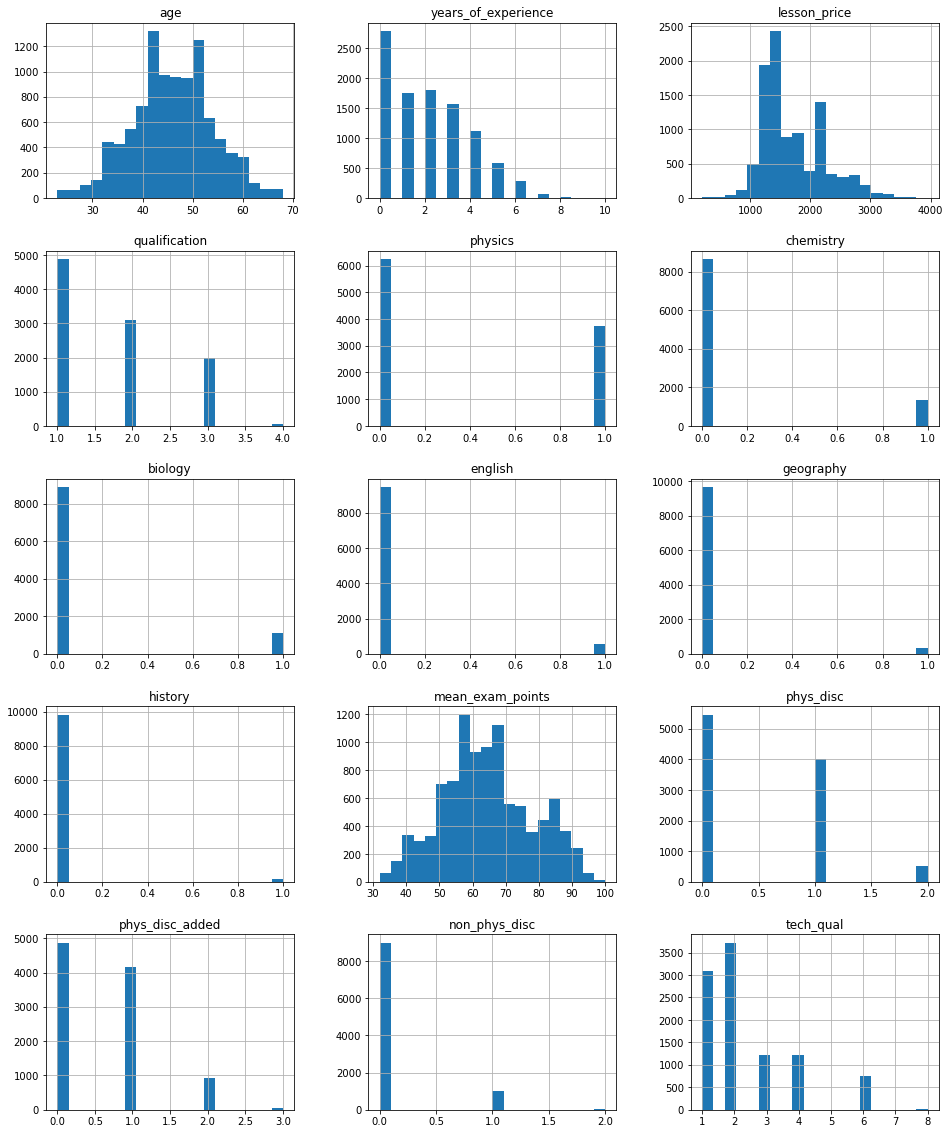

In [363]:
df_train.drop(columns=['Id']).hist(figsize=(16,20), bins=20, grid=True, layout=(-1, 3));

In [366]:
df_train[['phys_disc','mean_exam_points']].groupby('phys_disc').mean()

,mean_exam_points
phys_disc,
0.0,62.283933
1.0,66.657705
2.0,67.932203


In [367]:
df_train[['phys_disc_added','mean_exam_points']].groupby('phys_disc_added').mean()

,mean_exam_points
phys_disc_added,
0.0,62.076860
1.0,66.324657
2.0,67.023681
3.0,69.571429
